In [105]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy.spatial import distance

import torch
import torch.nn as nn
import torch.optim as optim
from utils import GaussianKDE

# Density estimation

In [56]:
ROOM_NUM = 1

with open(f'room_points_{ROOM_NUM}.npy', 'rb') as f:
    room_latent = np.load(f)

print(room_latent.shape)

room_pos = room_latent[:,:2]
print(room_pos.shape)

(10000, 4)
(10000, 2)


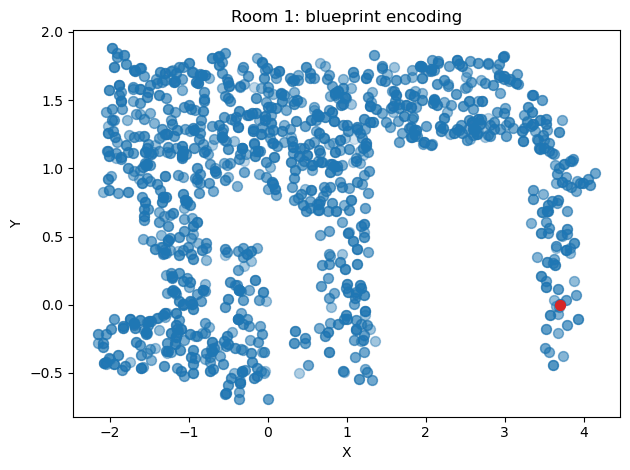

In [101]:
_ = plt.figure()
plt.scatter(room_pos[:,0], room_pos[:,1], color="tab:blue", s=50, alpha=.1)
plt.scatter([3.7], [0], color="tab:red", s=50)
plt.title(f"Room {ROOM_NUM}: blueprint encoding")
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

In [61]:
BANDWIDTH = 0.02
kde = GaussianKDE(X=torch.FloatTensor(room_pos), bw=BANDWIDTH)

(10000, 2)
tensor(0.1925) tensor(-inf)


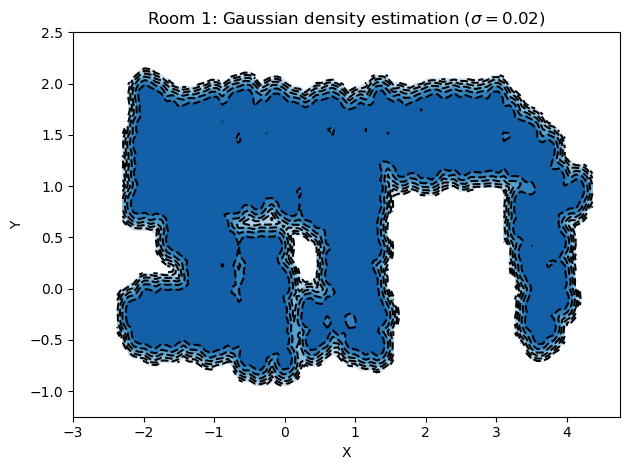

In [71]:
# TODO: make this automatic
xmin, xmax = -3, 4.75
ymin, ymax = -1.25, 2.5

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()]).T
print(positions.shape)
log_probs = kde.score_samples(positions)
print(log_probs.max(), log_probs.min())
f = np.reshape(kde.score_samples(positions).numpy().T, xx.shape)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title(f"Room {ROOM_NUM}: Gaussian density estimation" + r" ($\sigma={}$)".format(BANDWIDTH))
plt.tight_layout()
plt.show()

In [174]:
def potential_field(source, alpha, beta, kernel, target):
    atract = distance.cdist(source, target).squeeze(axis=-1)
    aux_kernel = kernel(source.T)
    repel = 1.0/(aux_kernel+0.001)
    return alpha*atract + beta*repel, aux_kernel

In [176]:
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

TARGET = np.array([[3.7, 0.0]])


methods = ["silverman", "scott", BANDWIDTH]
fig, ax = plt.subplots(2, len(methods), figsize=(15, 7))

for idx, method in enumerate(methods):
    # Peform the kernel density estimate
    if type(method) == float:
        method_ = np.sqrt(method)
    else:
        method_ = method
                    
    kernel = st.gaussian_kde(room_pos.T, bw_method=method_)
    pot_ex = lambda source: potential_field(source,
                                        alpha=1,
                                        beta=1,
                                        kernel=kernel,
                                        target=TARGET)

    # kernel_val = np.reshape(kernel(positions).T, xx.shape)
    pot_val, kernel_val = pot_ex(positions.T)
    pot_val = np.reshape(pot_val, xx.shape)
    kernel_val = np.reshape(kernel_val, xx.shape)
    
    ax[0, idx].set_xlim(xmin, xmax)
    ax[0, idx].set_ylim(ymin, ymax)
    ax[1, idx].set_xlim(xmin, xmax)
    ax[1, idx].set_ylim(ymin, ymax)
    # Contourf plot
    cfset = ax[0,idx].contourf(xx, yy, kernel_val, cmap="Blues")
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    cset = ax[0, idx].contour(xx, yy, kernel_val, colors='k')
    
     # Contourf plot
    cfset_pot = ax[1,idx].contourf(xx, yy, pot_val, cmap="Purples")
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    cset_pot = ax[1, idx].contour(xx, yy, pot_val, colors='k')
    
    
    # Label plot
    ax[1, idx].set_xlabel('X')
    if idx == 0:
        ax[0, idx].set_ylabel('Y')
        ax[1, idx].set_ylabel('Y')
    
    title = "bandwith using "
    if type(method) == float:
        title += r"$\sigma={}$".format(method)
    else:
        title += method.capitalize()
        
    ax[0, idx].set_title("KDE w/" + title)
    ax[1, idx].set_title("APF w/" + title)

plt.show()

In [109]:
pot_ex(np.array([[-1, 0.0]]))

array([[12.14473491]])

# Optimization

In [ ]:
def train_curve(optimizer_func, curve_func, init, num_updates=100):
    """
    Args:
        optimizer_func: Constructor of the optimizer to use. Should only take a parameter list
        curve_func: Loss function (e.g. pathological curvature)
        num_updates: Number of updates/steps to take when optimizing
        init: Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Returns:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    # https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/03-initialization-and-optimization.html 
    
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optim = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optim.zero_grad()
        loss.backward()
        optim.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points